In [1]:
#import model       #written in tensorflow from the original
import os
import random
import json
import util        #written in tensorflow from the original
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob as glob
from PIL import Image
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import vgg16part   #Have to change the cable

#import that model:
import import_ipynb
import model

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


2023-04-22 12:12:38.347828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from model.ipynb
GPU is available


In [2]:
#load util functions

ls_files_to_json = util.ls_files_to_json
make_input_batch = util.make_input_batch # Patch Permutation
open_img         = util.open_img
pickup_list      = util.pickup_list
images_batch     = util.images_batch
load_cfg         = util.load_cfg

In [3]:
#build models
build_generator     = model.build_generator
build_discriminator = model.build_discriminator

In [4]:
#Set the pathch size, can be 9,12,15,16
#MAX2KEEP, default = 10
PATCH_SIZE   = 9
MAX2KEEP  = 10
CFG = 'cfg.json'
supported_patch_size = {
    9 : 216,
    12: 240,
    15: 240,
    16: 256
}
# check args
if not PATCH_SIZE in supported_patch_size:
	exit("patch size not supported")

In [5]:
#set the impoertant parameters
# using the defalut values
PSI_D_SIZE   = supported_patch_size[PATCH_SIZE]
G_IMG_SIZE   = supported_patch_size[PATCH_SIZE]
VGG_L        = 1
VGG_FEATURES = 64

BATCH_SIZE   = 8
LAMBDA       = 5.0e-6

##---------------TODO:: Fill in the paths--------------------
MODEL_SAVE_PATH = 'available_models/'
STYLE_IMG       = 'style/morncolour_whale.jpeg'
TRAINSET_PATH   = 'archive'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


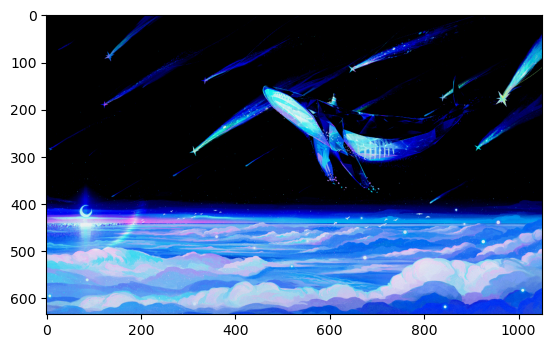

In [6]:
#load in the image and show it
style_img = open_img(STYLE_IMG)
img2 = style_img[:,:,::-1]
plt.imshow(img2)

In [7]:
#Training process

input_ls = ls_files_to_json(TRAINSET_PATH, ext=['png', 'bmp', 'jpg', 'jpeg'])
TRAIN_SET = len(input_ls)
print (TRAIN_SET)
gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
# with tf.Session() as sess:
	input_s = tf.placeholder(tf.float32, shape=[BATCH_SIZE, PSI_D_SIZE, PSI_D_SIZE, 3], name='inps')
	input_c = tf.placeholder(tf.float32, shape=[BATCH_SIZE, G_IMG_SIZE, G_IMG_SIZE, 3], name='inpc')

	vgg_c = vgg16part.Vgg16()
	with tf.name_scope("content_vgg"):
		vgg_c.build(input_c)

	g_state = build_generator(input_c, name='generator')

	vgg_g = vgg16part.Vgg16()
	with tf.name_scope("content_vgg"):
		vgg_g.build(g_state)

    #added reuse=tf.AUTO_REUSE for dp_real only
	dp_real = build_discriminator(input_s, patch_size=PATCH_SIZE, name='discriminator', reuse=tf.AUTO_REUSE)
	dp_fake = build_discriminator(g_state, patch_size=PATCH_SIZE, name='discriminator', reuse=True)

	d_raw = vgg_c.prob # 128 * 128 * 64
	d_gen = vgg_g.prob # 128 * 128 * 64

	d_real_d = tf.reduce_mean(dp_real)
	d_fake_d = tf.reduce_mean(dp_fake)

	mean_d_fake = tf.reduce_mean(dp_fake)
	d_fake_g = tf.reduce_mean((dp_fake) ** (1.0 - (dp_fake - mean_d_fake)))
	# d_fake_g = tf.reduce_mean(dp_fake)

	d_loss = -(tf.log(d_real_d) + tf.log(1 - d_fake_d))
	g_loss = (tf.norm(d_raw - d_gen) ** 2)*LAMBDA /(BATCH_SIZE*((G_IMG_SIZE/VGG_L)*(G_IMG_SIZE/VGG_L))*VGG_FEATURES)-tf.log(d_fake_g)
	# g_loss = tf.log(1 - d_fake_g) + (tf.norm(d_raw - d_gen) ** 2)*LAMBDA /(BATCH_SIZE*((G_IMG_SIZE/VGG_L)*(G_IMG_SIZE/VGG_L))*VGG_FEATURES)

	d_var_ls = tf.trainable_variables(scope='discriminator')
	# train_step_d = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5, beta2=0.9).minimize(d_loss, var_list=d_var_ls)
	update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
	with tf.control_dependencies(update_ops):
		train_step_d = tf.train.RMSPropOptimizer(5e-4).minimize(d_loss, var_list=d_var_ls)
	# train_step_d = tf.train.GradientDescentOptimizer(1e-3).minimize(d_loss, var_list=d_var_ls)

	g_var_ls = tf.trainable_variables(scope='generator')
	# train_step_g = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5, beta2=0.9).minimize(g_loss, var_list=g_var_ls)
	train_step_g = tf.train.RMSPropOptimizer(5e-4).minimize(g_loss, var_list=g_var_ls)
	# train_step_g = tf.train.GradientDescentOptimizer(1e-3).minimize(g_loss, var_list=g_var_ls)
	
	sess.run(tf.global_variables_initializer())
	var_ls = g_var_ls.append(d_var_ls)
	saver = tf.train.Saver(tf.trainable_variables(scope='generator'), max_to_keep=MAX2KEEP)
	epoch = 0
	train_cfg = load_cfg(CFG)
	if train_cfg['load_model']:
		chkpt_fname = tf.train.latest_checkpoint(MODEL_SAVE_PATH)
		saver.restore(sess, chkpt_fname)
	while epoch < train_cfg['epoch_lim']:
		train_cfg = load_cfg(CFG)
		random.shuffle(input_ls)
		travx = int(TRAIN_SET / BATCH_SIZE) + (1 if (TRAIN_SET % BATCH_SIZE) != 0 else 0)
		for offset in range(travx):
			train_cfg = load_cfg(CFG)
			sub_ls  = pickup_list(input_ls, BATCH_SIZE, offset * BATCH_SIZE)
			sub_img = images_batch(TRAINSET_PATH, sub_ls, prep=True,
								shape=(G_IMG_SIZE, G_IMG_SIZE), singleCh=False, remove_pad=True)	
			for td in range(train_cfg['D']['max_iter']):
				sess.run(train_step_d, feed_dict={
						input_s: make_input_batch(style_img, BATCH_SIZE, PSI_D_SIZE, PSI_D_SIZE, PATCH_SIZE),
						input_c: sub_img
					})
			for tg in range(train_cfg['G']['max_iter']):
				sess.run(train_step_g, feed_dict={
						input_c: sub_img
					})
			print('epoch %04d'%epoch, 'InnerProcess: %d/%d'%(offset, travx))

			if train_cfg['preview']:
				if train_cfg['view_iter'] == offset:
					util.silent_mkdir('preview/%d_%d'%(epoch, offset))
					util.save_batch_as_rgb_img(sess.run(g_state,
						feed_dict={input_c: sub_img}), 'preview/%d_%d'%(epoch, offset), prefix='0_')
			if train_cfg['save_model_iter'] == offset:
				saver.save(sess, os.path.join(MODEL_SAVE_PATH, "model"), global_step=epoch)


		cur_d_real = sess.run(d_real_d, feed_dict={
				input_s: make_input_batch(style_img, BATCH_SIZE, PSI_D_SIZE, PSI_D_SIZE, PATCH_SIZE),
				input_c: sub_img
			})
		cur_d_fake = sess.run(d_fake_d, feed_dict={
				input_c: sub_img
			})
		print('\33[1;32mEpoch %d D_TURN D real\33[0m = '%epoch, cur_d_real.mean())
		print('\33[1;31mEpoch %d D_TURN D fake\33[0m = '%epoch, cur_d_fake.mean())
		if epoch % train_cfg['export'] == 0:
			util.silent_mkdir('preview/%d'%epoch)
			util.save_batch_as_rgb_img(sess.run(g_state,
				feed_dict={input_c: sub_img}), 'preview/%d'%epoch, prefix='0_')
		if (epoch % train_cfg['save_step'] == 0 or epoch == train_cfg['save_at']):
			saver.save(sess, os.path.join(MODEL_SAVE_PATH, "model"), global_step=epoch)
		epoch = epoch + 1

9963
Metal device set to: Apple M1
/Users/ziyangning/Documents/EECS351/final_project/p2GAN/vgg16.npy


2023-04-22 12:13:27.136028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-22 12:13:27.136522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


npy file loaded
build model started


/Users/ziyangning/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


/Users/ziyangning/Documents/EECS351/final_project/p2GAN/vgg16.npy
npy file loaded
build model started
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-04-22 12:13:29.963920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-22 12:13:30.803624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-22 12:13:32.321334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0000 InnerProcess: 0/1246
epoch 0000 InnerProcess: 1/1246
epoch 0000 InnerProcess: 2/1246
epoch 0000 InnerProcess: 3/1246
epoch 0000 InnerProcess: 4/1246
epoch 0000 InnerProcess: 5/1246
epoch 0000 InnerProcess: 6/1246
epoch 0000 InnerProcess: 7/1246
epoch 0000 InnerProcess: 8/1246
epoch 0000 InnerProcess: 9/1246
epoch 0000 InnerProcess: 10/1246
epoch 0000 InnerProcess: 11/1246
epoch 0000 InnerProcess: 12/1246
epoch 0000 InnerProcess: 13/1246
epoch 0000 InnerProcess: 14/1246
epoch 0000 InnerProcess: 15/1246
epoch 0000 InnerProcess: 16/1246
epoch 0000 InnerProcess: 17/1246
epoch 0000 InnerProcess: 18/1246
epoch 0000 InnerProcess: 19/1246
epoch 0000 InnerProcess: 20/1246
epoch 0000 InnerProcess: 21/1246
epoch 0000 InnerProcess: 22/1246
epoch 0000 InnerProcess: 23/1246
epoch 0000 InnerProcess: 24/1246
epoch 0000 InnerProcess: 25/1246
epoch 0000 InnerProcess: 26/1246
epoch 0000 InnerProcess: 27/1246
epoch 0000 InnerProcess: 28/1246
epoch 0000 InnerProcess: 29/1246
epoch 0000 InnerProc

KeyboardInterrupt: 